
The realspace density autocorrelation function $\xi_{dd}$ between halos
Calculated using the Corrfunc open package, DD module

In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
from hankel import HankelTransform
from scipy.interpolate import InterpolatedUnivariateSpline as spline 
path ='/Users/ngoc/Desktop/Master-study/project'

In [3]:
#cosmological parameters
z        = 0.306
Omg_lamb = 0.685
Omg_m    = 1 - Omg_lamb
a        = 1/(1 + z)
E_a      = np.sqrt(Omg_m*(1+z)**3 + Omg_lamb)

In [4]:
#simulation parameter 
boxsize  = 2000            #[Mpc/h]
nthreads = 4               #The number of OpenMP threads to use
autocorr = 1 
nbins    = 50              #number of bins
r_min    = 1               #[Mpc/h]
r_max    = boxsize/3       #[Mpc/h]
bins     = np.logspace(np.log10(r_min), np.log10(r_max), nbins + 1)
ndata    = 8               #number of realizations (data sets)

In [5]:
xi = np.zeros((ndata,nbins))
r  = np.zeros((ndata,nbins))

set_data = "112345678"

for i in range (0,ndata):
#load positions of objects
    X = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'
                   +set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (1))
    Y = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'
                   +set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (2))
    Z = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'
                   +set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (3))
    
    weights = np.full_like(X,1)
    
    #calculate DD pairs, using module DD
    results_DD = DD(autocorr,
                    nthreads,
                    bins,
                    X, Y, Z,
                    weights1    = weights,
                    boxsize     = boxsize,
                    weight_type = 'pair_product',
                    output_ravg = True,
                    periodic    = True) 
    
    #calculate RR pairs
    N_halo = len(X)
    RR     = N_halo*(4./3.*np.pi*(bins[1::]**3 - bins[0:-1:]**3))*(N_halo-1)/boxsize**3
    DDpair = results_DD['npairs']
    weight = results_DD['weightavg']
    
    #write results into the 2D array
    xi[i]  = DDpair*weight/RR - 1
    r[i]   = results_DD['ravg']

In [6]:
    
r_mean  = np.zeros(nbins)
xi_mean = np.zeros(nbins)

for i in range(0,nbins):
    r_mean[i]  = np.mean(r[0:ndata,i])
    xi_mean[i] = np.mean(xi[0:ndata,i])
    
sd = np.zeros(nbins)    
error = np.zeros(nbins)
 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (xi[j,i] - xi_mean[i])**2      
    sd[i] = np.sqrt(a/(ndata-1))             #standard deviation
error = sd/np.sqrt(ndata)                    #standard error of the mean

In [9]:
b   = 3.11
k   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (0))
P   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (1))
P_k = spline(k, P)
r   = r_mean
h0  = HankelTransform(nu=1/2, N = 3000, h = 1e-5)

# xi density in real space
f_0 = lambda k: P_k(k)*k**(1/2)/(np.pi*2)**(3/2)
xi_theory = 1/np.sqrt(r)*h0.transform(f_0,r, ret_err=False, inverse=True)*b**2

Text(0.5, 1.0, '$\\xi_{dd}$ in realspace')

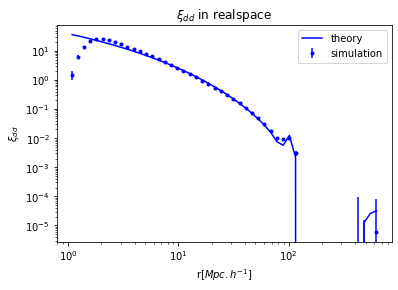

In [16]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(r_mean, xi_mean, yerr = error, fmt = 'b.', label='simulation')
ax.plot(r, xi_theory,'b-',label='theory')
ax.set_ylabel("$\\xi_{dd}$ ")
ax.set_xlabel("r$[Mpc.h^{-1}]$")
ax.legend()
#ax.set_ylim(22,29)
ax.set_title('$\\xi_{dd}$ in realspace')
#plt.savefig('xi_dd_realspace_Poisson.png')